In [1]:
import os
import numpy as np

In [2]:
from lsst.utils import getPackageDir

In [3]:
twinklesDir = getPackageDir('twinkles')
runMetaDataFile = os.path.join(twinklesDir, 'data/run1_metadata_v6.csv')
#InputVisitsFile = os.path.join(twinklesDir, 'data/SelectedKrakenVisits.csv')

In [4]:
import pandas as pd

In [5]:
runMetaDataFile

'/Users/rbiswas/doc/projects/DESC/Twinkles/data/run1_metadata_v6.csv'

In [6]:
from desc.monitor.dbConnection import dbInterface

/Users/rbiswas/src/LSST/sims_catalogs_generation/python/lsst/sims/catalogs/generation/db/dbConnection.py:438: UserWarning: Duplicate object type id 25 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
  'want globally unique id values')
/Users/rbiswas/src/LSST/sims_catalogs_generation/python/lsst/sims/catalogs/generation/db/dbConnection.py:438: UserWarning: Duplicate object type id 40 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
  'want globally unique id values')


In [7]:
dbConn = dbInterface(database='DESC_Twinkles_Level_2',
                     host='127.0.0.1', port='3307',
                     driver='mysql')

In [8]:
# Find the tables on the database
tables = dbConn._dbo.get_table_names()
print(tables)

['CcdVisit', 'ForcedSource', 'Object']


In [9]:
# Find the columns in the table CcdVisit
colNames = dbConn._dbo.get_column_names('CcdVisit')
#print(colNames)

In [10]:
obsHistIDsSuccess = set(dbConn._dbo.execute_arbitrary('SELECT visitId from CcdVisit')['visitId'])
# print(obsHistIDsSuccess)

In [11]:
# From https://github.com/DarkEnergyScienceCollaboration/Twinkles/issues/229 provided by @tony-johnson
DMFailures = set([681808, 1417225, 1957025, 2166623])

In [12]:
bandnames = 'ugrizy'

In [13]:
# PhoSim Failures (See Run1CPUTimes.ipynb notebook for detail. This is part of @sethdigel 's investigation)
run1meta = pd.read_csv(runMetaDataFile,index_col=0,usecols=["obshistid","expmjd","filter","rotskypos","altitude",\
                                                "rawseeing","airmass","sunalt","moonalt","moonphase","dist2moon","cputime",\
                                                "runlimit", "hostname"])
run1meta.rename(columns={'filter':'band'}, inplace=True)
run1meta['band'] = run1meta.band.apply(lambda x: bandnames[x])
phoSimFailedObsHistIDs = set(run1meta.query('runlimit==1').index.values) 

In [14]:
print('Number of phosim run failures due to Wall Clock Limit = {}'.format(len(phoSimFailedObsHistIDs)))

Number of phosim run failures due to Wall Clock Limit = 103


In [15]:
phosimFailures = run1meta.query('runlimit == 1')

In [16]:
grouped = phosimFailures.groupby('band')

In [17]:
phosimFailures.columns

Index([u'expmjd', u'band', u'rotskypos', u'altitude', u'rawseeing', u'airmass',
       u'moonalt', u'moonphase', u'dist2moon', u'sunalt', u'cputime',
       u'hostname', u'runlimit'],
      dtype='object')

In [18]:
grouped.agg({'expmjd':len, 'moonphase': [np.min, np.median, np.max], 'sunalt': [np.min, np.median, np.max]})

sunalt                        moonphase                       expmjd
           amin     median       amax       amin     median       amax    len
band                                                                         
g    -58.968357 -38.416821 -18.068682  46.966202  76.329056  99.172661   61.0
i    -46.724823 -26.373362 -16.371525  71.148628  94.767075  98.400993    9.0
r    -59.355564 -33.481647 -18.954361  44.532829  85.762169  99.191597   33.0

In [19]:
import seaborn as sns
sns.set()

/usr/local/software/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

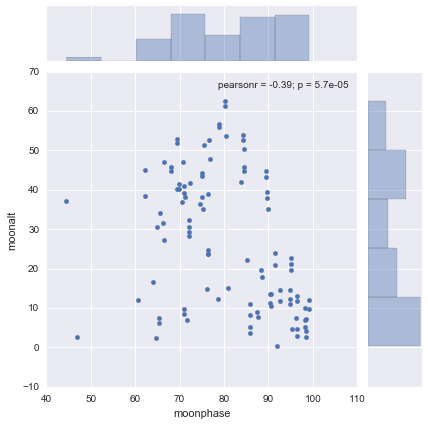

In [21]:
sns.jointplot(x='moonphase', y='moonalt', data=phosimFailures)

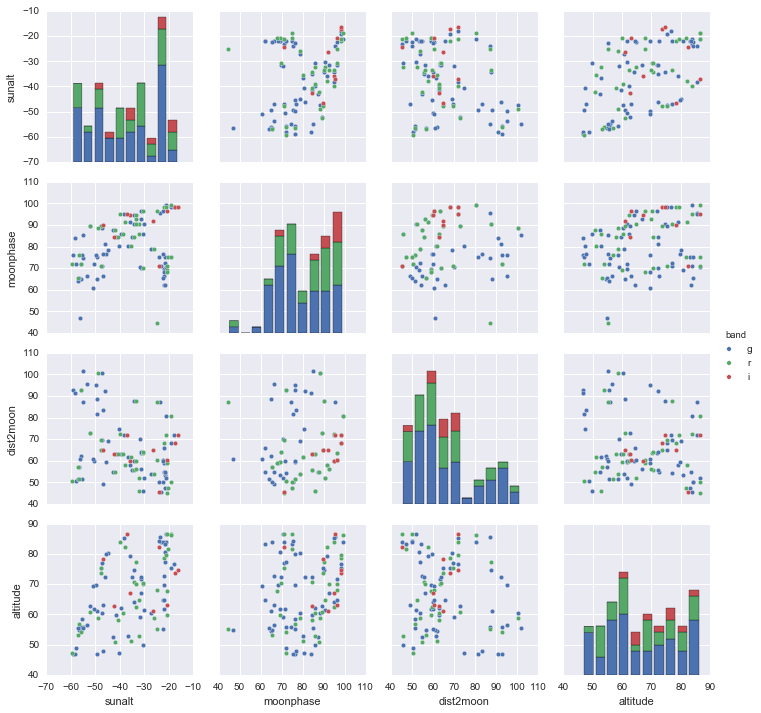

In [22]:
sns.pairplot(phosimFailures[['sunalt', 'moonphase', 'dist2moon', 'altitude', 'band']], hue='band')

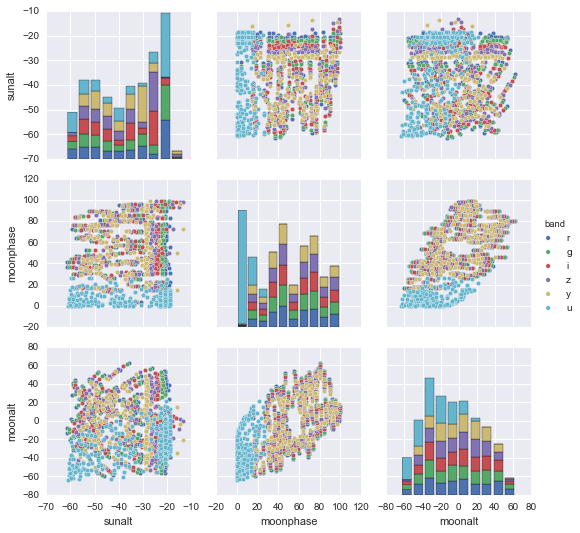

In [42]:
sns.pairplot(run1meta[['sunalt', 'moonphase', 'moonalt', 'band']], hue='band')

## Sanity Checks 

In [24]:
print('Total number of Observations = {}'.format(len(run1meta)))

Total number of Observations = 1227


In [25]:
InputVisits = set(run1meta.index.values)

In [26]:
failures = InputVisits -  obsHistIDsSuccess

#####  Number of failures should = number of inputs - number of success

In [27]:
assert len(failures) == len(InputVisits) -len(obsHistIDsSuccess)

#####  Failures consist of DM failures and phosim Failures

In [28]:
failures == phoSimFailedObsHistIDs.union(DMFailures)

True

In [29]:
failures - phoSimFailedObsHistIDs - DMFailures

set()

#####  Missing light curve points are all phosim failures

In [30]:
missingObs = set([709569, 726636, 732065])

In [31]:
missingObs.intersection(phoSimFailedObsHistIDs) == missingObs

True

In [32]:
run1meta.head()

,expmjd,band,rotskypos,altitude,rawseeing,airmass,moonalt,moonphase,dist2moon,sunalt,cputime,hostname,runlimit
obshistid,,,,,,,,,,,,,
200,59580.12500,r,256.415741,70.843140,0.744120,1.058624,-36.291664,3.884229,124.437035,-30.809488,30202.13,3,0
220,59580.13672,g,256.719421,67.748306,0.869226,1.080465,-36.219700,3.838714,124.329948,-32.225323,25589.48,3,0
230,59580.14062,i,256.751892,66.023071,0.791241,1.094442,-36.095425,3.812869,124.268242,-32.939915,28681.54,3,0
250,59580.15234,z,256.638519,62.998943,0.928894,1.122339,-35.733200,3.767761,124.158920,-34.057011,40600.57,3,0
276,59580.16406,y,256.267395,59.199089,1.132846,1.164212,-35.021816,3.711396,124.019577,-35.202927,66684.06,3,0


In [33]:
run1meta.ix[[709569, 726636, 732065]]

,expmjd,band,rotskypos,altitude,rawseeing,airmass,moonalt,moonphase,dist2moon,sunalt,cputime,hostname,runlimit
obshistid,,,,,,,,,,,,,
709569,60627.28906,g,256.526154,61.586487,0.789843,1.136965,10.604475,90.610908,52.176231,-30.269590,427379.28,4,1
726636,60654.07031,g,98.571197,72.598625,0.694619,1.047963,47.175110,66.521378,54.930840,-22.024441,427991.56,4,1
732065,60662.15234,g,255.388199,74.614113,0.453555,1.037172,13.664585,90.242516,87.642433,-34.176361,430691.41,4,1


In [34]:
obs = pd.read_csv(os.path.join(twinklesDir, 'data/SelectedKrakenVisits.csv'), index_col='obsHistID')

In [39]:
obs.ix[[709569, 726636, 732065]][['moonPhase', 'filtSkyBrightness', 'moonAlt', 'sunAlt', 'dist2Moon']]

,moonPhase,filtSkyBrightness,moonAlt,sunAlt,dist2Moon
obsHistID,,,,,
709569,90.610909,19.287629,0.185083,-0.528304,0.910647
726636,66.521378,20.071838,0.823361,-0.384399,0.958724
732065,90.242514,19.732872,0.238492,-0.596490,1.529649
